# Scaling Graphs
In this notebook we will work with random graphs. These graphs will act as a representative sample of graphs with higher number of nodes to evaluate the performance of different isomorphism tests.

In [1]:
import networkx as nx
from tqdm import tqdm
from collections import defaultdict

from counting import BasisCycleEmbedding
from weisfeiler_lehman import wl_embedding
from compare import compare_embeddings
from product.factor import get_factor_dict
from visual import plot_collisions
from generator import generate_graph_product_table


## Graph Generation
We will generate random graphs using the some chosen degree sequences. For each of these degree sequences we will generate graphs, in order to target classes of graphs difficult to decide for Weisfeiler Lehman test.

In [2]:
connected_graphs_leq_7 = [G for G in nx.graph_atlas_g() if not nx.is_empty(G) and nx.is_connected(G)]
er_graphs = defaultdict(list)

degree_seqs = [
    [1, 2, 2, 2, 2, 2, 3, 3, 3, 4],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [2, 2, 3, 3, 4, 4, 5, 5, 6, 6],
    [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
]


pre = defaultdict(list)
for degree_seq in degree_seqs:
    for seed in tqdm(range(5000)):
        G = nx.random_degree_sequence_graph(degree_seq, seed=seed, tries=1000)
        pre[tuple(degree_seq)].append(G) 


100%|██████████| 5000/5000 [00:04<00:00, 1000.65it/s]


In [3]:
pre_ = pre.copy() 
for degree_seq, graphs in pre.items():
    progress = tqdm(total=len(graphs), desc=f"Checking isomorphism for n:{len(graphs)} graphs")
    graphs_ = graphs.copy()
    while len(graphs_) > 0:
        H = graphs_.pop()
        progress.update(1)
        is_iso = False
        for G in graphs_:
            if nx.is_isomorphic(G, H):
                is_iso = True
                break
        if not is_iso:
            er_graphs[H.number_of_nodes()].append(H)
    

Checking isomorphism for n:5000 graphs:   0%|          | 0/5000 [00:00<?, ?it/s]

Checking isomorphism for n:5000 graphs: 100%|█████████▉| 4980/5000 [21:21<00:00, 146.30it/s]

In [4]:
er_graphs_list = [g for graphs in er_graphs.values() for g in graphs if g.number_of_nodes() <= 12]
len(er_graphs_list)

7910

## Isomorphism Tests
Next we will use basis cycle counting to create an embedding the generated graphs. Further we will apply graph products with different factor graphs to enhance the embeddings. Finally we will use the embeddings to compare the graphs and evaluate, how many collisions we have for graph pairs.

In [5]:
embed_config = {"size": 150, "operation": "basis_cycle"}
factors = get_factor_dict([3, 5, 7, 9], ["Path", "Star"])

print("Embedding graphs")
embedder = BasisCycleEmbedding()
cycle_embedded_graphs = embedder(er_graphs_list, 150)
print("Embedding graph products")
cycle_embedded_products = generate_graph_product_table(er_graphs_list, products=["Strong", "Tensor", "Modular"], factors=factors, embedding=embedder, embedding_size=150)

print("Comparing embeddings")
cycle_results = compare_embeddings(cycle_embedded_graphs, index=True)
cycle_product_results = cycle_embedded_products.map(lambda x: compare_embeddings(x, index=True))

print(f"Generated graphs without graph product application have {cycle_results[0]} collisions")

print("Cycle product results")
cycle_product_results.map(lambda x: x[0])

Embedding graphs
Embedding graph products


Checking isomorphism for n:5000 graphs: 100%|██████████| 5000/5000 [21:37<00:00, 146.30it/s]

Comparing embeddings
Generated graphs without graph product application have 1188081 collisions
Cycle product results


Graph Product,Strong,Tensor,Modular
Factor Graph,,,
P3,13458,856913,642
P5,27,4077,310
P7,12,165,319
P9,12,27,321
S3,116328,852517,465
S5,168603,852509,184
S7,72608,852488,155
S9,101683,852517,153


Now we will compare these results with isomorphism testing using Weisfeiler Lehman algorithm.

In [6]:
wl_embedded_graphs = wl_embedding(er_graphs_list, 10)
wl_results = compare_embeddings(wl_embedded_graphs, index=True)
print(f"Results: {wl_results[0]} collisions")

Results: 1794 collisions


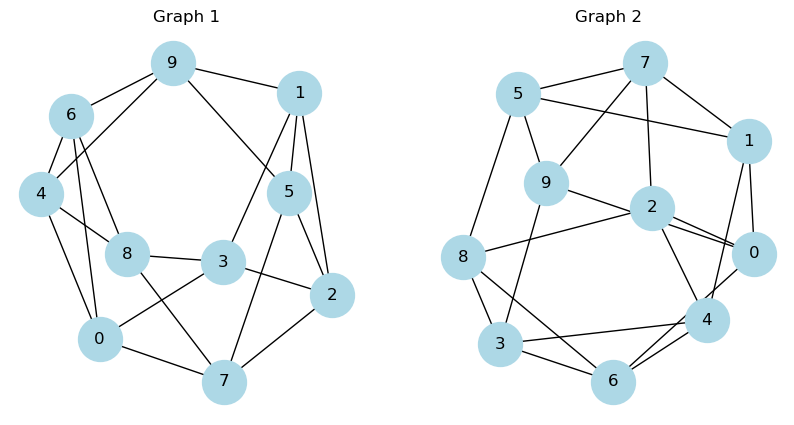

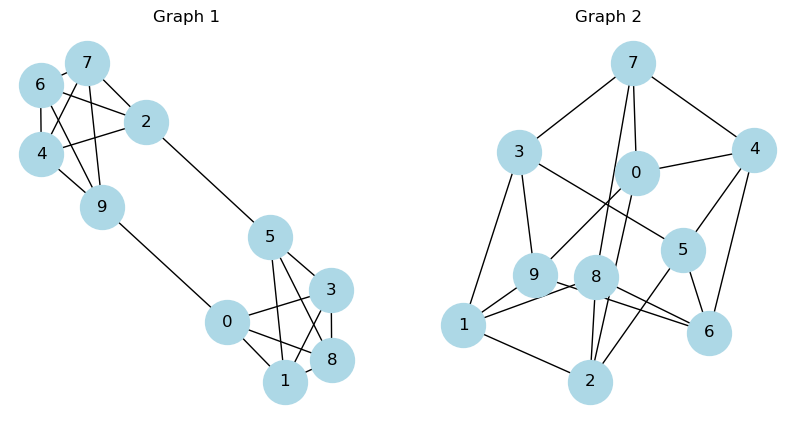

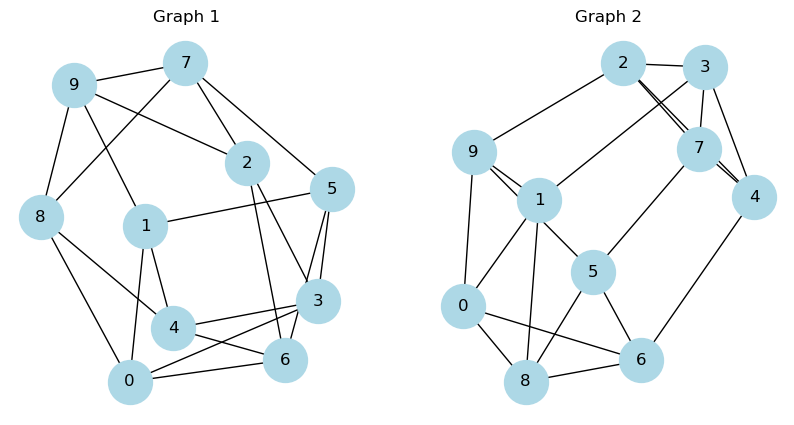

In [7]:
plot_collisions(wl_results[1], er_graphs_list)

In [8]:
for graph in er_graphs_list:
    for H in er_graphs_list:
        if graph != H:
            if nx.is_isomorphic(graph, H):
                print(f"Graphs {graph} and {H} are isomorphic")
                break